In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, GRU, Dense, Reshape,Bidirectional, LSTM
from tensorflow.keras.layers import Layer, GlobalMaxPooling1D, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import time

In [ ]:
# Load dataset
data = pd.read_csv("/content/dataset_full.csv")
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Preprocessing
data = data.dropna().drop_duplicates()
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)

In [ ]:
# === Neural Field Attention Layer ===
class NeuralFieldAttention(keras.layers.Layer):
    def __init__(self, timesteps=5, lambda_strength=0.2, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super().build(input_shape)

    def call(self, inputs):
        I = inputs
        u = tf.zeros_like(I)

        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)
            activation = tf.nn.relu(u)
            delta = tf.reduce_mean(tf.abs(I - tf.reduce_mean(I, axis=1, keepdims=True)), axis=-1, keepdims=True)
            delta = tf.tile(delta, [1, 1, inputs.shape[-1]])
            u = u + (-u + interaction + I + self.lambda_strength * delta)

        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * inputs, axis=1)
        return attended_output

    def get_config(self):
        config = super().get_config()
        config.update({
            'timesteps': self.timesteps,
            'lambda_strength': self.lambda_strength
        })
        return config


In [ ]:
# === Preprocessing (Assuming data is already loaded) ===
X = data.drop(columns=['phishing'])
y = data['phishing']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Build lightweight CNN + BiLSTM + Neural Field Attention model
model = Sequential()

# Lighter CNN block
model.add(Conv1D(16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))

# Lighter BiLSTM
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.2))

# Neural Field Attention
model.add(NeuralFieldAttention(timesteps=5, lambda_strength=0.2))

# Smaller dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 109, 16)             │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 54, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 54, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 52, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 26, 64)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 26, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention_1             │ (None, 64)                  │           4,096 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,593 (103.88 KB)

 Trainable params: 26,593 (103.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === Callbacks ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch + 1} Time: {epoch_times[-1]:.2f}s")

time_callback = keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)

In [ ]:
# === Train Model ===
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping, time_callback],
                    verbose=1)

Epoch 1/50
2180/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.9085 - Precision: 0.7279 - Recall: 0.9488 - accuracy: 0.8582 - loss: 0.3340Epoch 1 Time: 115.84s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 116s 49ms/step - AUC: 0.9085 - Precision: 0.7279 - Recall: 0.9488 - accuracy: 0.8582 - loss: 0.3340 - val_AUC: 0.9645 - val_Precision: 0.7971 - val_Recall: 0.9502 - val_accuracy: 0.8980 - val_loss: 0.2351
Epoch 2/50
2180/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9574 - Precision: 0.8129 - Recall: 0.9062 - accuracy: 0.8946 - loss: 0.2438Epoch 2 Time: 114.06s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 114s 37ms/step - AUC: 0.9574 - Precision: 0.8129 - Recall: 0.9062 - accuracy: 0.8946 - loss: 0.2438 - val_AUC: 0.9722 - val_Precision: 0.8142 - val_Recall: 0.9521 - val_accuracy: 0.9073 - val_loss: 0.2155
Epoch 3/50
2179/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.9640 - Precision: 0.8323 - Recall: 0.9090 - accuracy: 0.9043 - loss: 0.2271Epoch 3 Time: 82.25s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step -

In [ ]:
# === Evaluation ===
y_pred = (model.predict(X_test) > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step

Metrics:
Accuracy: 0.9507
Precision: 0.9433
Recall: 0.9139
AUC: 0.9422
Confusion Matrix:
[[11008   335]
 [  525  5574]]


In [ ]:
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)

print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


FAR: 0.0295
FRR: 0.0861


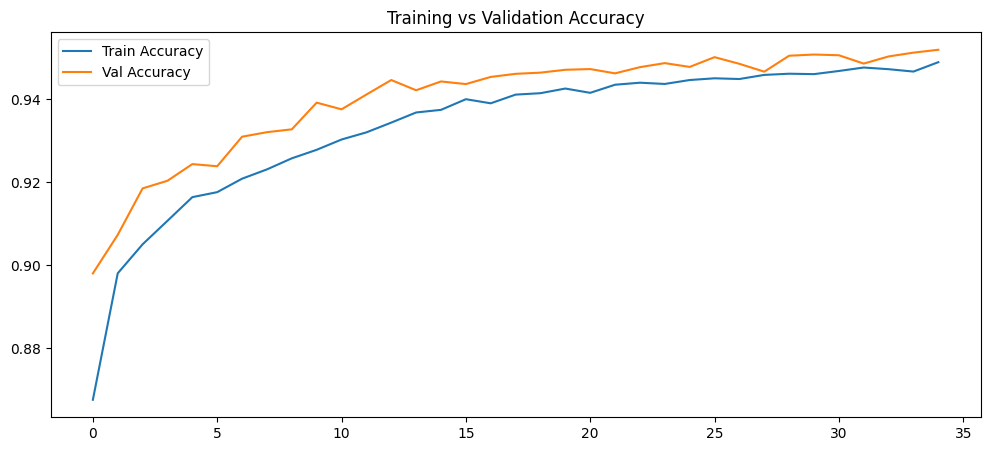

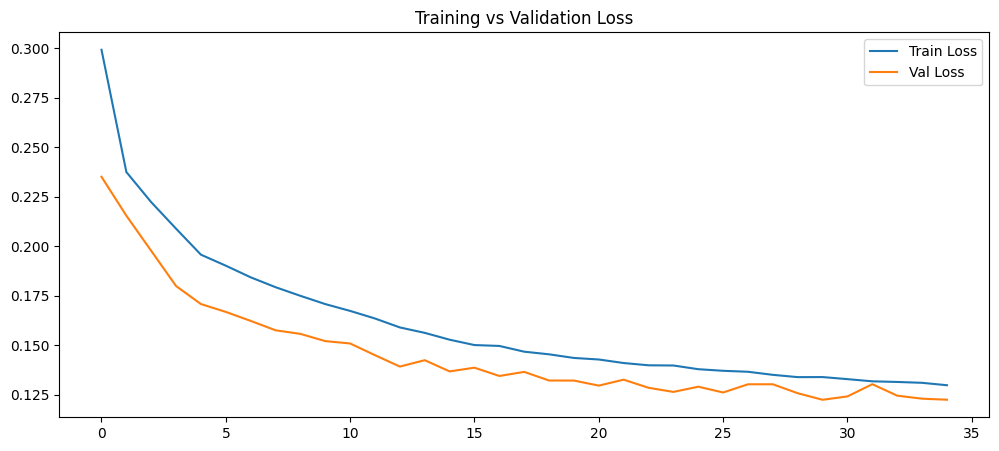

In [ ]:
# === Visualize Training ===
np.save("model_history_cnn_bilstm_nfa.npy", history.history)

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()